In [9]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
from models.constant_diffusivity import ConstantDiffusivityNeuralNetwork
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results
from trainers.train import train_loop

In [10]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data\linear_homogeneous\linear_homogeneous.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results\linear_homogeneous')
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results\linear_homogeneous\modelo_prueba')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_PATH)

Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\linear_homogeneous
Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\linear_homogeneous\modelo_prueba


In [11]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data\linear_homogeneous\linear_homogeneous.pkl


In [12]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [13]:
# Tratamiento de los datos para dividirlos en train y test
X_train = torch.Tensor(dataset['X_train']).unsqueeze(1)
y_train = TensOps(torch.tensor(dataset['y_train'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_train = TensOps(torch.tensor(dataset['k_train'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

X_val = torch.Tensor(dataset['X_val']).unsqueeze(1)
y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

X_np = X_train
y_np = y_train.values
K_np = K_train.values

X_train_np, X_test_np, y_train_np, y_test_np, K_train_np, K_test_np = train_test_split(X_np, y_np, K_np, test_size=0.2, random_state=42)

X_train = X_train_np
X_test = X_test_np

y_train = TensOps(y_train_np, space_dimension=y_train.space_dim, contravariance=0, covariance=0)
y_test = TensOps(y_test_np, space_dimension=y_train.space_dim, contravariance=0, covariance=0)

K_train = TensOps(K_train_np, space_dimension=K_train.space_dim, contravariance=0, covariance=0)
K_test = TensOps(K_test_np, space_dimension=K_train.space_dim, contravariance=0, covariance=0)

In [14]:
# Arquitectura del modelo
input_shape = X_train[0].shape  # [1, 10, 8]
hidden1_dim = 10
hidden2_dim = 10
output_shape = y_train.values[0].shape  # [1, 10, 10]

In [15]:
# Se carga el modelo y el optimizador
model = ConstantDiffusivityNeuralNetwork(input_shape, hidden1_dim, hidden2_dim, output_shape)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

model, optimizer, lists = load_results(model, optimizer, MODEL_RESULTS_PATH)


In [16]:
train_total_loss_list = lists['train_total_loss_list']
train_e_loss_list = lists['train_e_loss_list']
train_pi1_loss_list = lists['train_pi1_loss_list']
train_pi2_loss_list = lists['train_pi2_loss_list']
train_pi3_loss_list = lists['train_pi3_loss_list']

test_total_loss_list = lists['test_total_loss_list']
test_e_loss_list = lists['test_e_loss_list']
test_pi1_loss_list = lists['test_pi1_loss_list']
test_pi2_loss_list = lists['test_pi2_loss_list']
test_pi3_loss_list = lists['test_pi3_loss_list']

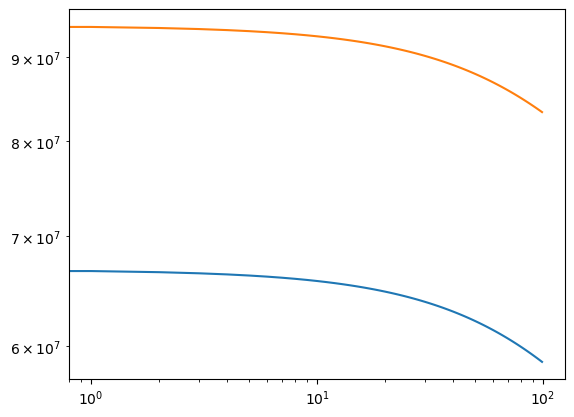

In [17]:
plt.plot(train_total_loss_list)
plt.plot(test_total_loss_list)
plt.xscale('log')
plt.yscale('log')
plt.show()

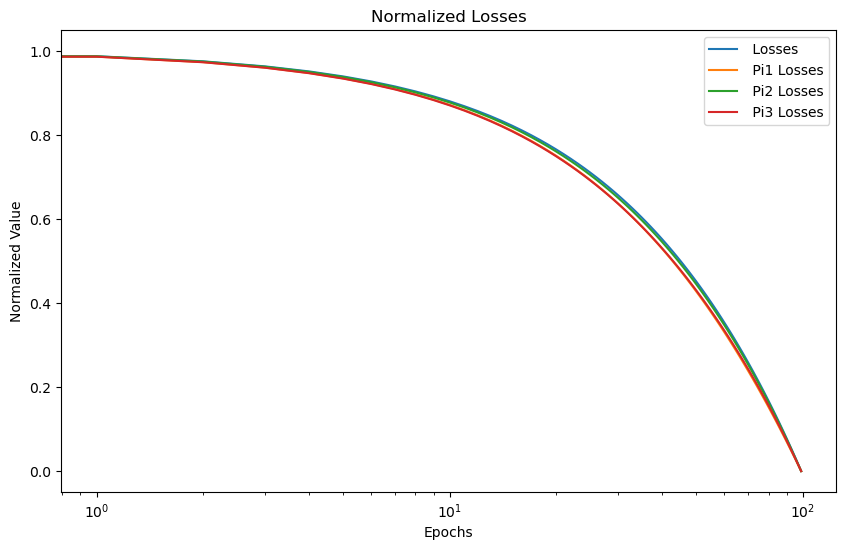

In [18]:

# Función para normalizar listas
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# Normalizar las listas
normalized_e_losses = normalize(np.array(train_e_loss_list))
normalized_pi1_losses = normalize(np.array(train_pi1_loss_list))
normalized_pi2_losses = normalize(np.array(train_pi2_loss_list))
normalized_pi3_losses = normalize(np.array(train_pi3_loss_list))

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(normalized_e_losses, label=' Losses')
plt.plot(normalized_pi1_losses, label=' Pi1 Losses')
plt.plot(normalized_pi2_losses, label=' Pi2 Losses')
plt.plot(normalized_pi3_losses, label=' Pi3 Losses')

# Añadir leyenda y etiquetas
plt.title('Normalized Losses')
plt.xlabel('Epochs')
plt.ylabel('Normalized Value')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
# plt.grid()

In [19]:
def relative_error_stats(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    minimo = np.min(prediction_error)
    maximo = np.max(prediction_error)
    primer_cuartil = np.percentile(prediction_error, 25)
    mediana = np.percentile(prediction_error, 50)
    tercer_cuartil = np.percentile(prediction_error, 75)

    # Imprimir los resultados
    print(f"Mínimo: {minimo:.2e}")
    print(f"Máximo: {maximo:.2e}")
    print(f"Primer cuartil (Q1): {primer_cuartil:.2e}")
    print(f"Mediana (Q2): {mediana:.2e}")
    print(f"Tercer cuartil (Q3): {tercer_cuartil:.2e}")

In [30]:
y_pred, K_pred = model(X_val)

y_pred = TensOps(y_pred, space_dimension=2, contravariance=0, covariance=0)
K_pred = TensOps(K_pred.unsqueeze(0).repeat(y_pred.values.shape[0], 1, 1, 1), space_dimension=2, contravariance=0, covariance=0)

In [32]:
u_validation = y_val.values.detach()
u_prediction = y_pred.values.detach()

relative_error_stats(u_validation, u_prediction)

Mínimo: 1.27e-01
Máximo: 2.04e+01
Primer cuartil (Q1): 2.99e-01
Mediana (Q2): 3.95e-01
Tercer cuartil (Q3): 6.61e-01


In [34]:
K_validation = zo.My(zo.Mx(K_val)).values.detach()
K_prediction = K_pred.values.detach()

relative_error_stats(K_validation, K_prediction)

Mínimo: 1.40e+00
Máximo: 1.40e+00
Primer cuartil (Q1): 1.40e+00
Mediana (Q2): 1.40e+00
Tercer cuartil (Q3): 1.40e+00


In [37]:
qx = azo.scalar_product(K_pred, zo.Dx(-y_val, D)).values
qy = azo.scalar_product(K_pred, zo.Dy(-y_val, D)).values

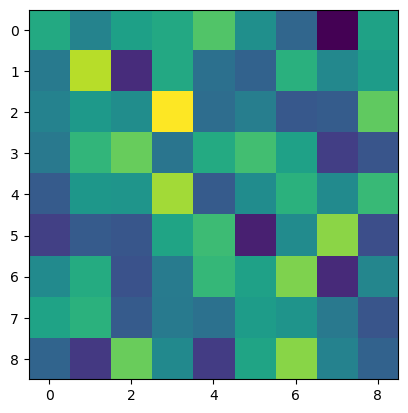

In [39]:
plt.imshow(qx.detach()[0, 0])